# Exercise - Swaption Vol Skew


#### Notation Commands

$$\newcommand{\Black}{\mathcal{B}}
\newcommand{\Blackcall}{\Black_{\mathrm{call}}}
\newcommand{\Blackput}{\Black_{\mathrm{put}}}
\newcommand{\EcondS}{\hat{S}_{\mathrm{conditional}}}
\newcommand{\Efwd}{\mathbb{E}^{T}}
\newcommand{\Ern}{\mathbb{E}^{\mathbb{Q}}}
\newcommand{\Tfwd}{T_{\mathrm{fwd}}}
\newcommand{\Tunder}{T_{\mathrm{bond}}}
\newcommand{\accint}{A}
\newcommand{\carry}{\widetilde{\cpn}}
\newcommand{\cashflow}{C}
\newcommand{\convert}{\phi}
\newcommand{\cpn}{c}
\newcommand{\ctd}{\mathrm{CTD}}
\newcommand{\disc}{Z}
\newcommand{\done}{d_{1}}
\newcommand{\dt}{\Delta t}
\newcommand{\dtwo}{d_{2}}
\newcommand{\flatvol}{\sigma_{\mathrm{flat}}}
\newcommand{\flatvolT}{\sigma_{\mathrm{flat},T}}
\newcommand{\float}{\mathrm{flt}}
\newcommand{\freq}{m}
\newcommand{\futprice}{\mathcal{F}(t,T)}
\newcommand{\futpriceDT}{\mathcal{F}(t+h,T)}
\newcommand{\futpriceT}{\mathcal{F}(T,T)}
\newcommand{\futrate}{\mathscr{f}}
\newcommand{\fwdprice}{F(t,T)}
\newcommand{\fwdpriceDT}{F(t+h,T)}
\newcommand{\fwdpriceT}{F(T,T)}
\newcommand{\fwdrate}{f}
\newcommand{\fwdvol}{\sigma_{\mathrm{fwd}}}
\newcommand{\fwdvolTi}{\sigma_{\mathrm{fwd},T_i}}
\newcommand{\grossbasis}{B}
\newcommand{\hedge}{\Delta}
\newcommand{\ivol}{\sigma_{\mathrm{imp}}}
\newcommand{\logprice}{p}
\newcommand{\logyield}{y}
\newcommand{\mat}{(n)}
\newcommand{\nargcond}{d_{1}}
\newcommand{\nargexer}{d_{2}}
\newcommand{\netbasis}{\tilde{\grossbasis}}
\newcommand{\normcdf}{\mathcal{N}}
\newcommand{\notional}{K}
\newcommand{\pfwd}{P_{\mathrm{fwd}}}
\newcommand{\pnl}{\Pi}
\newcommand{\price}{P}
\newcommand{\probexer}{\hat{\mathcal{P}}_{\mathrm{exercise}}}
\newcommand{\pvstrike}{K^*}
\newcommand{\refrate}{r^{\mathrm{ref}}}
\newcommand{\rrepo}{r^{\mathrm{repo}}}
\newcommand{\spotrate}{r}
\newcommand{\spread}{s}
\newcommand{\strike}{K}
\newcommand{\swap}{\mathrm{sw}}
\newcommand{\swaprate}{\cpn_{\swap}}
\newcommand{\tbond}{\mathrm{fix}}
\newcommand{\ttm}{\tau}
\newcommand{\value}{V}
\newcommand{\vega}{\nu}
\newcommand{\years}{\tau}
\newcommand{\yearsACT}{\tau_{\mathrm{act/360}}}
\newcommand{\yield}{Y}$$


## Swaption Vol Data

The file `data/swaption_vol_data_2025-06-30.xlsx` has market data on the implied volatility skews for swaptions. Note that it has several columns:
* `expry`: expiration of the swaption
* `tenor`: tenor of the underlying swap
* `model`: the model by which the volatility is quoted. (All are Black.)
* `-200`, `-100`, etc.: The strike listed as difference from ATM strike (bps). Note that ATM is considered to be the **forward swapa rate** which you can calculate.


Your data: you will use a single row of this data for the `1x4` swaption.
* date: `2025-06-30`
* expiration: 1yr
* tenor: 4yrs


## Rate Data

The file `data/cap_curves_2025-06-30.xlsx` gives 
* SOFR swap rates, 
* their associated discount factors
* their associated forward interest rates.

You will not need the cap data (flat or forward vols) for this problem.


## The Swaption

Consider the following swaption with the following features:
* underlying is a fixed-for-floating (SOFR) swap
* the underlying swap has **quarterly** payment frequency
* this is a **payer** swaption, which gives the holder the option to **pay** the fixed swap rate and receive SOFR.


In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import log, sqrt, erf

FILE_NAME_1 = 'data/cap_curves_2025-06-30.xlsx'
FILE_NAME_2 = 'data/swaption_vol_data_2025-06-30.xlsx'
cap_curves = pd.read_excel(FILE_NAME_1)
swaption_vol_data = pd.read_excel(FILE_NAME_2)

cap_curves.head()

,tenor,swap rates,spot rates,discounts,forwards,flat vols,fwd vols
0,0.25,0.042353,0.042353,0.989523,NaN,NaN,NaN
1,0.50,0.040859,0.040852,0.979883,0.039351,0.156842,0.156842
2,0.75,0.039391,0.039372,0.971043,0.036414,0.180709,0.201708
3,1.00,0.038115,0.038083,0.962807,0.034217,0.204576,0.240464
4,1.25,0.036704,0.036653,0.955417,0.030938,0.242127,0.328341


In [28]:
swaption_vol_data.head()

,reference,instrument,model,date,expiration,tenor,-200,-100,-50,-25,0,25,50,100,200
0,SOFR,swaption,black,2025-06-30,1,1,72.250,46.870,39.100,36.000,33.39,31.300,29.760,28.17,28.660
1,SOFR,swaption,black,2025-06-30,1,2,65.780,44.400,37.970,35.460,33.39,31.750,30.530,29.19,29.300
2,SOFR,swaption,black,2025-06-30,1,3,57.870,40.610,35.560,33.650,32.11,30.920,30.060,29.14,29.290
3,SOFR,swaption,black,2025-06-30,1,4,54.405,38.565,33.925,32.195,30.83,29.805,29.095,28.43,28.885
4,SOFR,swaption,black,2025-06-30,1,5,50.940,36.520,32.290,30.740,29.55,28.690,28.130,27.72,28.480


### SABR Model

Use the quoted volatility skew to fit a SABR model.
* Throughout, parameterize, `beta=.75`.


### 1.1.
Estimate $(\alpha,\rho,\nu)$ via the SABR formula. Feel free to use the `sabr` function in `cmds/volskew.py`.

Report the values of these parameters.


In [29]:
import sys
sys.path.insert(0, '.')
from cmds.volskew import sabr, sabrATM, solve_alpha
from scipy.optimize import minimize
from scipy.stats import norm

BETA = 0.75
T_EXPIRY = 1.0
NOTIONAL = 100

##########################################################
# Forward swap rate for 1x4 swaption (start=1yr, end=5yr, quarterly)
##########################################################
tenors = cap_curves['tenor'].values
discounts = cap_curves['discounts'].values

Z_start = discounts[tenors == 1.0][0]
Z_end   = discounts[tenors == 5.0][0]

payment_tenors = np.arange(1.25, 5.25, 0.25)
Z_payments = np.array([discounts[np.isclose(tenors, t)][0] for t in payment_tenors])
ANNUITY = 0.25 * np.sum(Z_payments)
F = (Z_start - Z_end) / ANNUITY

print(f'Forward swap rate F = {F*100:.4f}%')
print(f'Annuity = {ANNUITY:.6f}')

##########################################################
# Market vol data for 1x4 swaption
##########################################################
row = swaption_vol_data[(swaption_vol_data['expiration']==1) & (swaption_vol_data['tenor']==4)].iloc[0]
offsets = np.array([-200, -100, -50, -25, 0, 25, 50, 100, 200])
market_vols = np.array([row[o] for o in offsets]) / 100
strikes_mkt = F + offsets / 10000
sigma_atm = market_vols[offsets == 0][0]

##########################################################
# SABR calibration: solve alpha from ATM, optimize (rho, nu)
##########################################################
def objective(params):
    rho, nu = params
    if nu <= 0 or rho <= -1 or rho >= 1:
        return 1e10
    alpha = solve_alpha(F, T_EXPIRY, sigma_atm, BETA, rho, nu)
    if alpha <= 0:
        return 1e10
    model_vols = sabr(F, strikes_mkt, T_EXPIRY, alpha, BETA, rho, nu)
    return np.sum((model_vols - market_vols)**2)

best_res = None
best_sse = 1e10
for r0 in [-0.8, -0.5, -0.3, 0.0, 0.3]:
    for n0 in [0.3, 0.5, 0.7, 1.0, 1.5]:
        res = minimize(objective, [r0, n0], method='Nelder-Mead',
                      options={'maxiter': 100000, 'xatol': 1e-12, 'fatol': 1e-16})
        if res.fun < best_sse:
            best_sse = res.fun
            best_res = res

RHO, NU = best_res.x
ALPHA = solve_alpha(F, T_EXPIRY, sigma_atm, BETA, RHO, NU)

# Report
params_df = pd.DataFrame({
    'SABR Parameters': [BETA, ALPHA, NU, RHO, best_sse]
}, index=[r'beta ($\beta$)', r'alpha ($\alpha$)', r'nu ($\nu$)', r'rho ($\rho$)', 'fit error'])

display(params_df)

Forward swap rate F = 3.2698%
Annuity = 3.603238


,SABR Parameters
beta ($\beta$),0.750000
alpha ($\alpha$),0.128662
nu ($\nu$),0.717328
rho ($\rho$),-0.373485
fit error,0.000066


### 1.2.
Create a grid of strikes of `[.0025, .09]`, with grid spacing of `10bps`, (.0010).

Use the SABR model parameterized above to calculate the volatility for each of these strikes.

* Plot the SABR curve, and also include the market quotes in the plot.

* Conceptually, does the SABR curve fit these points well? Perfectly?


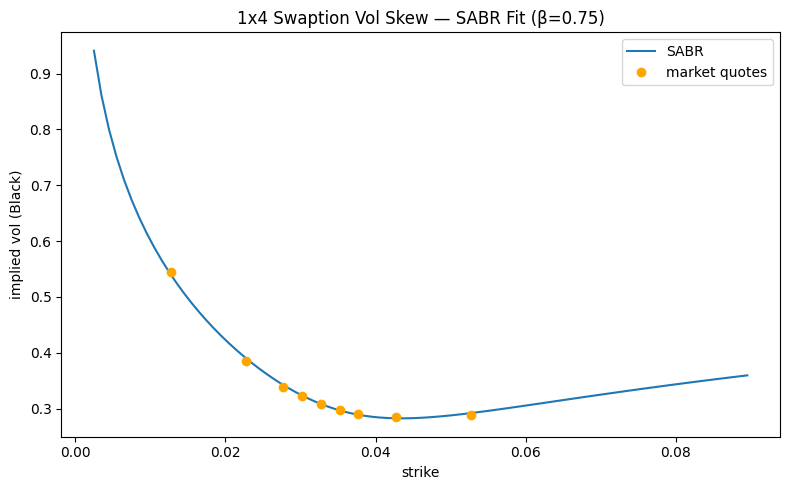

The SABR curve fits the market quotes well but not perfectly.
SABR is an approximation formula with 3 free parameters fitting 9 points,
so some small residuals are expected.


In [30]:
# Strike grid from 0.25% to 9% with 10bps spacing
strike_grid = np.arange(0.0025, 0.0901, 0.0010)

# SABR vols on the grid
sabr_vols = sabr(F, strike_grid, T_EXPIRY, ALPHA, BETA, RHO, NU)

# Plot
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(strike_grid, sabr_vols, '-', label='SABR')
ax.plot(strikes_mkt, market_vols, 'o', color='orange', label='market quotes')
ax.set_xlabel('strike')
ax.set_ylabel('implied vol (Black)')
ax.legend()
ax.set_title('1x4 Swaption Vol Skew — SABR Fit (β=0.75)')
plt.tight_layout()
plt.show()

print("The SABR curve fits the market quotes well but not perfectly.")
print("SABR is an approximation formula with 3 free parameters fitting 9 points,")
print("so some small residuals are expected.")

### 1.3.
Suppose we want to price the `1y4y` swaption but with a far out-of-the-money strike of `5%`. 

* Use the SABR vol at this strike to price the swaption.

(Note that this strike is far outside the range for which we have market quotes, and even if we do have quotes, they likely are not liquid on a given day.)


In [31]:
def black_payer_swaption(F, K, T, sigma, annuity, notional=100):
    """Price a payer swaption using Black's formula.
    Payer = option to pay fixed K, receive floating.
    Value = Notional * Annuity * [F*N(d1) - K*N(d2)]
    """
    d1 = (np.log(F / K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return notional * annuity * (F * norm.cdf(d1) - K * norm.cdf(d2))

# SABR vol at K = 5%
K_otm = 0.05
sigma_otm = sabr(F, K_otm, T_EXPIRY, ALPHA, BETA, RHO, NU)

price_otm = black_payer_swaption(F, K_otm, T_EXPIRY, sigma_otm, ANNUITY, NOTIONAL)

print(f'SABR vol at K={K_otm*100:.0f}%: {sigma_otm*100:.2f}%')
print(f'Price of the OTM swaption at strike {K_otm*100:.2f}% is ${price_otm:.4f}.')

SABR vol at K=5%: 28.77%
Price of the OTM swaption at strike 5.00% is $0.1287.


### 1.4.

Use the ATM implied volatility to fit $\alpha$, (sometimes denoted $\sigma_0$.) That is, for any choice of $(\rho,\nu)$, solve a quadratic equation to get $\alpha$ as a function of those two parameters, along with $\beta$, which is at its selected (not estimated) value.

Recall that we have a simple relationship between ATM vol and $\alpha$.

$$\sigma_\text{ATM} = \alpha\frac{B}{F^{1-\beta}}$$
where $B$ is defined in the discussion note. It is a quadratic expression of $\alpha$ along with $(\beta,\rho,\nu)$.

This decouples the optimization. We solve for $(\rho,\nu)$ and $\alpha$ as a function of the other two parameters.

Consider using the function `sabrATM` in `cmds/volskew.py`.


In [32]:
# The decoupled approach: for any (rho, nu), solve alpha from the ATM constraint.
# ATM formula: sigma_ATM = (alpha / F^(1-beta)) * B(alpha)
# where B(alpha) = 1 + [(1-beta)^2/(24*F^(2(1-beta))) * alpha^2
#                       + rho*beta*nu/(4*F^(1-beta)) * alpha
#                       + (2 - 3*rho^2)/24 * nu^2] * T
#
# This is a cubic in alpha, which solve_alpha solves via root-finding.
# The optimization then only searches over (rho, nu) — a 2D problem.

# Demonstrate: given the fitted (rho, nu), recover alpha
alpha_recovered = solve_alpha(F, T_EXPIRY, sigma_atm, BETA, RHO, NU)
vol_check = sabrATM(F, T_EXPIRY, alpha_recovered, BETA, RHO, NU)

print(f'Market ATM vol:     {sigma_atm*100:.4f}%')
print(f'Recovered alpha:    {alpha_recovered:.6f}')
print(f'SABR ATM vol check: {vol_check*100:.4f}%')
print(f'ATM match error:    {abs(vol_check - sigma_atm):.2e}')
print()

# Show that this is exactly what we did in 1.1 — the optimization was 2D over (rho, nu),
# with alpha pinned by the ATM constraint at each step.
print('This is the approach already used in 1.1:')
print(f'  Optimized (rho, nu) = ({RHO:.4f}, {NU:.4f})')
print(f'  Implied alpha       = {ALPHA:.4f}')
print(f'  ATM vol is matched exactly by construction.')

Market ATM vol:     30.8300%
Recovered alpha:    0.128662
SABR ATM vol check: 30.8300%
ATM match error:    1.21e-13

This is the approach already used in 1.1:
  Optimized (rho, nu) = (-0.3735, 0.7173)
  Implied alpha       = 0.1287
  ATM vol is matched exactly by construction.


# 2. SABR and Risk Management


Consider how an **increase** of `50bps` in the underlying rate impacts the price of the `1y4y` ATM swaption.

Here, we are assuming that
* the rate change will impact the forward swap rate directly, one-for-one with other rates.
* the shift happens one week after the original quote date.

Of course, in reality, a rate change
* may price in early to some degree if it is expected
* may not impact the forward swap rate one-for-one. We would need to model how the discount curve changes and what that change (level, slope, curvature?) would do to the forward swap rate.


### 2.1

Use Black's equation to re-price the `1y4y` swaption with
* the same ATM volatility
* an underlying (forward swap) rate `increased` `50bps`.
* the same time-to-maturities. (We should decrease these all by 1/365, but we focus here on the delta effects rather than the theta. And it would be a small impact anyone.)

Report 
* the new price
* the change in price divided by `50bps`, (a numerical delta.)


In [33]:
SHIFT = 0.0050  # 50bps
F_new = F + SHIFT
K_atm = F  # strike = original ATM forward swap rate

# Original ATM payer swaption price
price_0 = black_payer_swaption(F, K_atm, T_EXPIRY, sigma_atm, ANNUITY, NOTIONAL)

# Re-price with F shifted up 50bps, same ATM vol, same strike
price_static = black_payer_swaption(F_new, K_atm, T_EXPIRY, sigma_atm, ANNUITY, NOTIONAL)

# Numerical delta (static vol)
delta_static = (price_static - price_0) / SHIFT

print(f'Original ATM price (F={F*100:.2f}%, K={K_atm*100:.2f}%, σ={sigma_atm*100:.2f}%): ${price_0:.2f}')
print(f'Shifted price      (F={F_new*100:.2f}%, K={K_atm*100:.2f}%, σ={sigma_atm*100:.2f}%): ${price_static:.2f}')
print(f'Numerical delta (static vol) = (${price_static:.2f} - ${price_0:.2f}) / {SHIFT} = {delta_static:.2f}')

Original ATM price (F=3.27%, K=3.27%, σ=30.83%): $1.44
Shifted price      (F=3.77%, K=3.27%, σ=30.83%): $2.62
Numerical delta (static vol) = ($2.62 - $1.44) / 0.005 = 234.43


### 2.2

Now, we consider how the volatility may change with the underlying shift `up` of `50bps`.

Using the same SABR parameters from `2.1`, and the strike grid from `2.2`, plot the new SABR curve accounting for the underlying rate shifting `up` `50bps`.


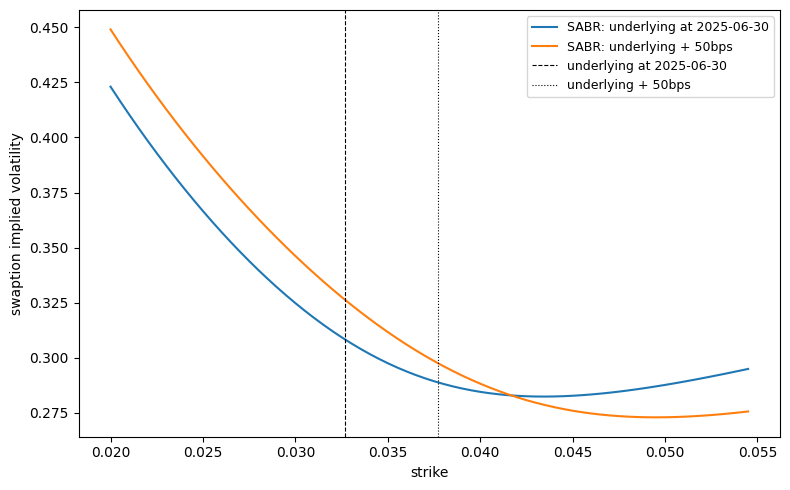

In [34]:
# SABR curves: original F vs shifted F_new, same (alpha, beta, rho, nu)
# Use a narrower strike grid to zoom in around ATM
plot_grid = np.arange(0.020, 0.055, 0.0005)

sabr_vols_orig = sabr(F, plot_grid, T_EXPIRY, ALPHA, BETA, RHO, NU)
sabr_vols_shifted = sabr(F_new, plot_grid, T_EXPIRY, ALPHA, BETA, RHO, NU)

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(plot_grid, sabr_vols_orig, '-', label=f'SABR: underlying at 2025-06-30')
ax.plot(plot_grid, sabr_vols_shifted, '-', label=f'SABR: underlying + 50bps')
ax.axvline(F, color='k', linestyle='--', linewidth=0.8, label=f'underlying at 2025-06-30')
ax.axvline(F_new, color='k', linestyle=':', linewidth=0.8, label=f'underlying + 50bps')
ax.set_xlabel('strike')
ax.set_ylabel('swaption implied volatility')
ax.legend(fontsize=9)
plt.tight_layout()
plt.show()

### 2.3

Calculate the new volatility specifically for the pre-shift ATM strike.

Use this in Black's formula similar to `3.1`, where the only change is the volatility now reflects the shift in the underlying (not the strike).

Report
* the new price
* the change in price divided by `50bps`


In [35]:
# SABR vol at the original ATM strike K=F, but with underlying shifted to F_new
sigma_dynamic = sabr(F_new, K_atm, T_EXPIRY, ALPHA, BETA, RHO, NU)

# Re-price with dynamic vol
price_dynamic = black_payer_swaption(F_new, K_atm, T_EXPIRY, sigma_dynamic, ANNUITY, NOTIONAL)
delta_dynamic = (price_dynamic - price_0) / SHIFT

print(f'SABR vol at K={K_atm*100:.2f}% with F_new={F_new*100:.2f}%: {sigma_dynamic*100:.2f}%')
print(f'(vs static ATM vol: {sigma_atm*100:.2f}%)')
print()

# Summary tables
prices_df = pd.DataFrame(
    [[price_0, price_static],
     [np.nan, price_dynamic]],
    index=['no change in vol', 'dynamic vol'],
    columns=['no change in rates', 'shift in rates']
)
display(prices_df)

delta_df = pd.DataFrame(
    {'price change': [delta_static, delta_dynamic]},
    index=['no change in vol', 'dynamic vol']
)
display(delta_df)

SABR vol at K=3.27% with F_new=3.77%: 32.63%
(vs static ATM vol: 30.83%)



,no change in rates,shift in rates
no change in vol,1.443366,2.615523
dynamic vol,NaN,2.696523


,price change
no change in vol,234.431433
dynamic vol,250.631465


### 2.4

How much different is the (dynamic) delta which accounts for the shift in volatility from the (static) delta in `3.1`?


In [36]:
rel_change = (delta_dynamic - delta_static) / delta_static * 100

print(f'Static delta (no vol change):  {delta_static:.2f}')
print(f'Dynamic delta (SABR vol adj):  {delta_dynamic:.2f}')
print(f'Relative change to delta: {rel_change:5.2f}%.')
print()
print('The dynamic delta is larger than the static delta.')
print('When rates rise, the original ATM strike becomes in-the-money for the payer swaption.')
print('SABR with negative rho implies that vol increases as the strike moves further')
print('below the (shifted) forward rate, amplifying the price increase beyond what')
print('a static vol assumption would predict.')

Static delta (no vol change):  234.43
Dynamic delta (SABR vol adj):  250.63
Relative change to delta:  6.91%.

The dynamic delta is larger than the static delta.
When rates rise, the original ATM strike becomes in-the-money for the payer swaption.
SABR with negative rho implies that vol increases as the strike moves further
below the (shifted) forward rate, amplifying the price increase beyond what
a static vol assumption would predict.
